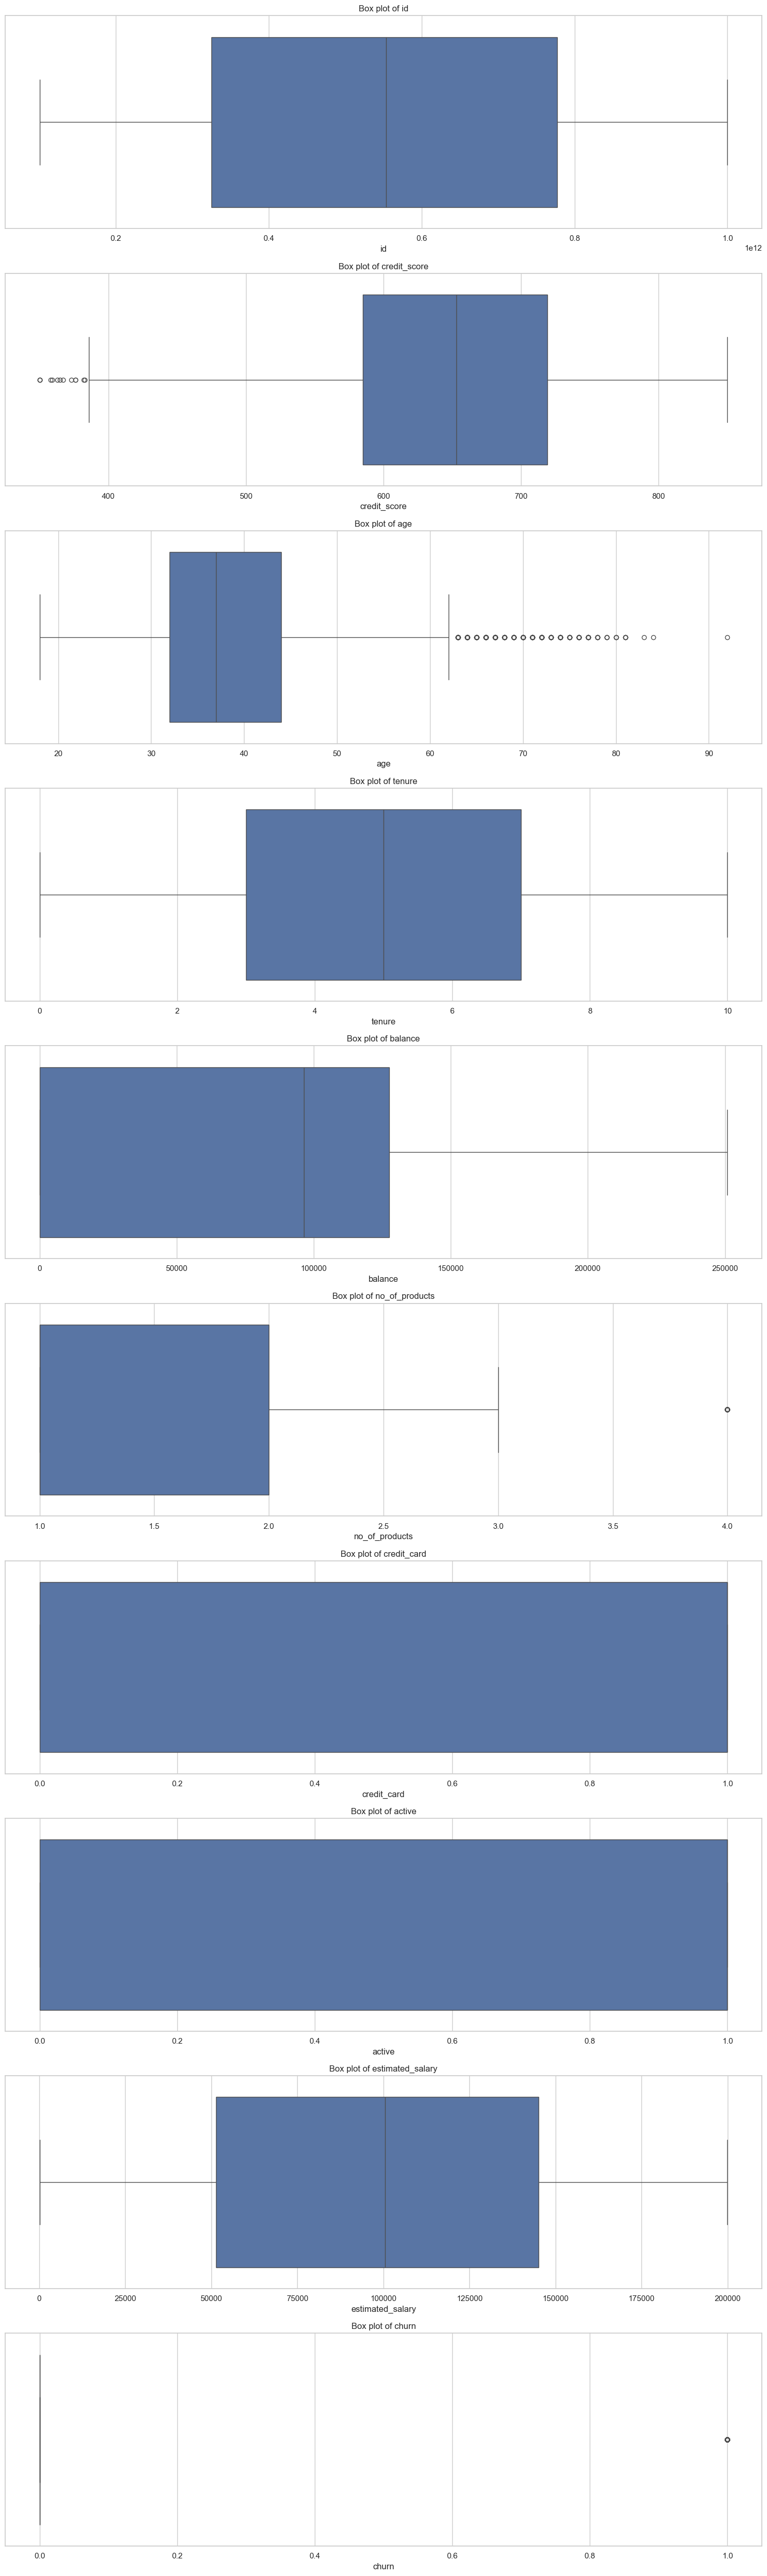

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('train.csv')

sns.set(style="whitegrid")

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, len(numerical_columns) * 5))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(data[column], orient='h')
    plt.title(f'Box plot of {column}')

plt.tight_layout()
plt.show()

In [44]:
Q1 = data['age'].quantile(0.25)
Q3 = data['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_no_outliers = data[(data['age'] >= lower_bound) & (data['age'] <= upper_bound)]

data_no_outliers.to_csv('outlier_removed.csv', index=False)

print("Outliers removed from 'age' column and saved to 'outlier_removed.csv'")

Outliers removed from 'age' column and saved to 'outlier_removed.csv'


In [45]:
data_no_outliers = pd.read_csv('outlier_removed.csv')

churn_distribution = data_no_outliers['churn'].value_counts()

print("Distribution of values in 'churn':")
print(churn_distribution)

Distribution of values in 'churn':
churn
0    6126
1    1588
Name: count, dtype: int64


In [46]:
from sklearn.utils import resample

data_no_outliers = pd.read_csv('outlier_removed.csv')

majority_class = data_no_outliers[data_no_outliers['churn'] == 0]
minority_class = data_no_outliers[data_no_outliers['churn'] == 1]

minority_class_upsampled = resample(
    minority_class,
    replace=True,                 
    n_samples=len(majority_class), 
    random_state=1                 
)

upsampled_data = pd.concat([majority_class, minority_class_upsampled])

upsampled_data.to_csv('upsample_outlier.csv', index=False)

print("Upsampling complete. Data saved to 'upsample_outlier.csv'.")

Upsampling complete. Data saved to 'upsample_outlier.csv'.


In [47]:
df = pd.read_csv('upsample_outlier.csv')

In [48]:
df.head()

,id,credit_score,state,gender,age,tenure,balance,no_of_products,credit_card,active,estimated_salary,churn
0,269976851321,686,Mumbai,Male,32,6,0.0,2,1,1,179093.26,0
1,685873070169,632,New Delhi,Male,42,4,119624.6,2,1,1,195978.86,0
2,955830487825,683,Mumbai,Female,40,1,0.0,2,0,0,75762.00,0
3,915329300883,759,Mumbai,Female,45,8,0.0,2,1,1,99251.24,0
4,166959004465,426,Mumbai,Female,34,3,0.0,2,1,1,61230.83,0


In [49]:
df['churn'].value_counts()

churn
0    6126
1    6126
Name: count, dtype: int64

In [50]:
df = pd.read_csv('upsample_outlier.csv')

print("Data types of each column:")
print(data.dtypes)

Data types of each column:
id                    int64
credit_score          int64
state                object
gender               object
age                   int64
tenure                int64
balance             float64
no_of_products        int64
credit_card           int64
active                int64
estimated_salary    float64
churn                 int64
dtype: object


In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])

print(df['gender'].value_counts())
print(df[['gender']].head())

gender
1    6251
0    6001
Name: count, dtype: int64
   gender
0       1
1       1
2       0
3       0
4       0


In [52]:
df.drop('state',axis=1,inplace=True)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


X = df.drop('churn', axis=1)  
y = df['churn']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    model.fit(X_train, y_train)             
    y_pred = model.predict(X_test)          
    print(classification_report(y_test, y_pred))  



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.61      0.42      0.50      1271
           1       0.53      0.72      0.61      1180

    accuracy                           0.56      2451
   macro avg       0.57      0.57      0.55      2451
weighted avg       0.57      0.56      0.55      2451


Model: Random Forest
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1271
           1       0.92      0.97      0.94      1180

    accuracy                           0.94      2451
   macro avg       0.94      0.94      0.94      2451
weighted avg       0.94      0.94      0.94      2451


Model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1271
           1       0.79      0.77      0.78      1180

    accuracy                           0.79      2451
   macro avg       0.79      0.79      0.79      245

In [58]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': randint(50, 500), 
    'max_depth': randint(3, 20),  
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20),  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False]  
}

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=1
)

random_search_rf.fit(X_train_scaled, y_train)

best_rf = random_search_rf.best_estimator_
print("Best Random Forest Model:", best_rf)

best_params_rf = random_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Random Forest Model: RandomForestClassifier(bootstrap=False, max_depth=17, min_samples_leaf=2,
                       min_samples_split=11, n_estimators=435, random_state=42)
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 435}


In [59]:
rf = RandomForestClassifier(
    n_estimators=435,  
    max_depth=17,       
    min_samples_split=11,  
    min_samples_leaf=2,    
    max_features='sqrt',  
    bootstrap=False,    
    random_state=42
)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.9368
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1271
           1       0.92      0.95      0.94      1180

    accuracy                           0.94      2451
   macro avg       0.94      0.94      0.94      2451
weighted avg       0.94      0.94      0.94      2451

Confusion Matrix for Random Forest:
[[1175   96]
 [  59 1121]]
